# 训练文本数据读取

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import os
path = "/content/drive/My Drive"
os.chdir(path)
!ls

 2238322.gdoc	   'Modern Family s01e01 Episode Script | SS.gdoc'
 2238322.pdf	   'Modern Family s01e01 Episode Script | SS.pdf'
'Colab Notebooks'   ptb.train.txt
 fractal.mp4	    WechatIMG7.jpeg


In [0]:
with open("ptb.train.txt", encoding="utf8") as f:
    lines = f.readlines()

In [0]:
rawdata = [line.split() for line in lines]
voc = list(set([word for line in rawdata for word in line]))

In [0]:
word_to_idx = {word: idx for idx, word in enumerate(voc)}
idx_to_word = voc
idxdata = [[word_to_idx[word] for word in line] for line in rawdata]

# 构造共现矩阵

In [0]:
import torch
import numpy as np
from collections import defaultdict, Counter

class GloveDataset:
    def __init__(self, text, window_size=5):
        co_mat = defaultdict(Counter)
        for line in text:
            for i in range(len(line)):
                for j in range(1, window_size+1):
                    if i - j >= 0:
                        co_mat[line[i]][line[i-j]] += 1.0/j
                    if i + j < len(line):
                        co_mat[line[i]][line[i+j]] += 1.0/j
        self._i_idx = list()
        self._j_idx = list()
        self._xij = list()

        for w, cnt in co_mat.items():
            for c, v in cnt.items():
                self._i_idx.append(w)
                self._j_idx.append(c)
                self._xij.append(v)
        
        self._i_idx = torch.tensor(self._i_idx)
        self._j_idx = torch.tensor(self._j_idx)
        self._xij = torch.tensor(self._xij)
    
    def get_batches(self, batch_size):
        rand_ids = torch.tensor(np.random.choice(len(self._xij), len(self._xij), replace=False))
        
        for i in range(0, len(rand_ids), batch_size):
            batch_ids = rand_ids[i:i+batch_size]
            yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]

dataset = GloveDataset(idxdata)

# 构造Glove模型

In [0]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Glove(nn.Module):
    def __init__(self, voc_size, embed_size):
        super(Glove, self).__init__()
        self.W1 = nn.Embedding(voc_size, embed_size)
        self.W2 = nn.Embedding(voc_size, embed_size)
        self.b1 = nn.Embedding(voc_size, 1)
        self.b2 = nn.Embedding(voc_size, 1)
        torch.nn.init.xavier_normal_(self.W1.weight)
        torch.nn.init.xavier_normal_(self.W2.weight)
        torch.nn.init.xavier_normal_(self.b1.weight)
        torch.nn.init.xavier_normal_(self.b2.weight)
    
    def forward(self, i_indices, j_indices):
        w_i = self.W1(i_indices)
        w_j = self.W2(j_indices)
        b_i = self.b1(i_indices).squeeze()
        b_j = self.b2(j_indices).squeeze()
        return torch.sum(w_i * w_j, axis=-1) + b_i + b_j

glove = Glove(voc_size=len(idx_to_word), embed_size=100).to(device)

# Weighted Mean Square Loss Function

In [0]:
class WeightedMSE(nn.Module):
    def __init__(self, x_max, alpha):
        super(WeightedMSE, self).__init__()
        self.x_max = x_max
        self.alpha = alpha
    
    def _weighted(self, x):
        wx = (x / self.x_max) ** self.alpha
        return torch.min(wx, torch.ones_like(wx))

    def forward(self, inputs, targets):
        loss = nn.functional.mse_loss(inputs, targets, reduction="none")
        weighted = self._weighted(targets)
        loss = weighted * loss
        return torch.mean(loss)

criterion = WeightedMSE(x_max=100, alpha=0.75)

# 模型训练

In [16]:
import time

learning_rate = 0.05
num_epochs = 100
batch_size = 64

optimizer = torch.optim.Adagrad(glove.parameters(), lr=learning_rate)
loss_list = []
for epoch in range(num_epochs):
    total_loss = 0.
    start = time.time()
    for targets, i_indices, j_indices in dataset.get_batches(batch_size):
        targets = targets.to(device)
        i_indices = i_indices.to(device)
        j_indices = j_indices.to(device)
        inputs = glove(i_indices, j_indices)
        loss = criterion(inputs, torch.log(targets))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
    loss_list.append(total_loss/len(idx_to_word))
    if (epoch+1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs}. Avg Loss: {total_loss / len(idx_to_word):.4f}. Time: {time.time()-start:.3f}s")

Epoch: 10/100. Avg Loss: 0.1535. Time: 35.440s
Epoch: 20/100. Avg Loss: 0.1137. Time: 36.319s
Epoch: 30/100. Avg Loss: 0.0983. Time: 35.920s
Epoch: 40/100. Avg Loss: 0.0895. Time: 36.608s
Epoch: 50/100. Avg Loss: 0.0836. Time: 35.835s
Epoch: 60/100. Avg Loss: 0.0792. Time: 35.870s
Epoch: 70/100. Avg Loss: 0.0758. Time: 35.847s
Epoch: 80/100. Avg Loss: 0.0731. Time: 36.617s
Epoch: 90/100. Avg Loss: 0.0708. Time: 36.262s
Epoch: 100/100. Avg Loss: 0.0689. Time: 36.193s


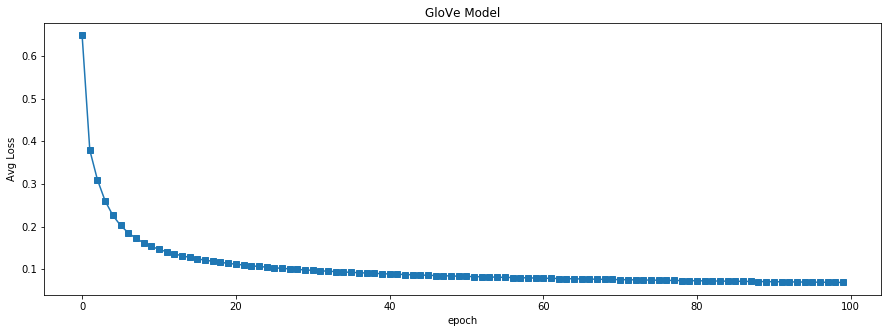

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('Avg Loss')
plt.title('GloVe Model')
plt.show()

#相似性检验

In [0]:
def get_similarity(word, k, embed):
    W = embed.data
    x = W[word_to_idx[word]]
    cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
    _, topk = torch.topk(cos, k+1)
    for i in topk[1:]:
        print(f"cosine sim={cos[i]:.3f}: {idx_to_word[i]}.")

In [88]:
get_similar("has", 3, glove.W1.weight + glove.W2.weight)

cosine sim=0.646; had
cosine sim=0.612; been
cosine sim=0.584; have
